# Visualization

## 1 Setup

In [1]:
import os
import glob
from math import ceil
from collections import defaultdict


import numpy as np
import pandas as pd
from PIL import Image, ImageFont

import shap
import visualkeras
from tensorflow.keras.models import load_model
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Rescaling
from sklearn.model_selection import train_test_split

In [2]:
# configure the later used shap.DeepExplainer to be able to handle these layers
shap.explainers._deep.deep_tf.op_handlers['FusedBatchNormV3'] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers['AddV2'] = shap.explainers._deep.deep_tf.passthrough

In [3]:
# random number generator with seed for reproducability of the results
rng = np.random.default_rng(seed=42)

In [4]:
# initialize font to be used later in visualkeras model visualizations
font = ImageFont.truetype("arial.ttf", 32)

# creating custom color map for visualkeras for consistent coloring between the two models
# and because visualkeras by default only uses five different colors
color_map = defaultdict(dict)
color_map[Rescaling]['fill'] = '#E6600D'
color_map[Conv2D]['fill'] = '#E09D00'
color_map[BatchNormalization]['fill'] = '#C14646'
color_map[Activation]['fill'] = '#AB218E'
color_map[Dropout]['fill'] = '#0092D1'
color_map[MaxPooling2D]['fill'] = '#1A9898'
color_map[Flatten]['fill'] = '#759421'
color_map[Dense]['fill'] = '#925ACE'

## 2 Emotion-Classifier

### 2.1 Load and Prepare Model and Data

In [5]:
emotion_classifier = load_model(os.path.join(os.path.dirname('__file__'), '../models/emotion_classifier.h5'))

In [6]:
data_emotion = pd.read_csv(os.path.join(os.path.dirname('__file__'), '../../data/emotion/fer2013.csv'))
labels_emotion = pd.read_csv(os.path.join(os.path.dirname('__file__'), '../../data/emotion/fer2013new.csv'))


n_samples = len(data_emotion)
width = 48
height = 48


orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger',
                    'disgust', 'fear', 'contempt', 'unknown', 'NF']

# split data into input and labels
y_e = np.array(labels_emotion[orig_class_names])
X_e = np.zeros((n_samples, width, height, 1))
for i in range(n_samples):
    X_e[i] = np.fromstring(data_emotion['pixels'][i], dtype=int, sep=' ').reshape((height, width, 1))

# Using mask to remove unknown or NF images
y_mask = y_e.argmax(axis=-1)
mask = y_mask < orig_class_names.index('unknown')
X_e = X_e[mask]
y_e = y_e[mask]

# Convert to probabilities between 0 and 1
y_e = y_e[:, :-2] * 0.1

# Add contempt to neutral and remove it
y_e[:, 0] += y_e[:, 7]
y_e = y_e[:, :7]

test_size_e = ceil(len(X_e) * 0.1)

# split data 90:10
x_train_e, x_test_e, y_train_e, y_test_e = train_test_split(X_e,
                                                            y_e,
                                                            test_size=test_size_e,
                                                            random_state=48)

### 2.2 Initialize Shap

In [7]:
# a smaller sample of the corresponding training set has to be used as background for the DeepExplainer
background_e = x_train_e[rng.choice(x_train_e.shape[0], 500, replace=False)]

In [8]:
emotion_explainer = shap.DeepExplainer(emotion_classifier, background_e)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


### Visualize Emotion Model Architecture

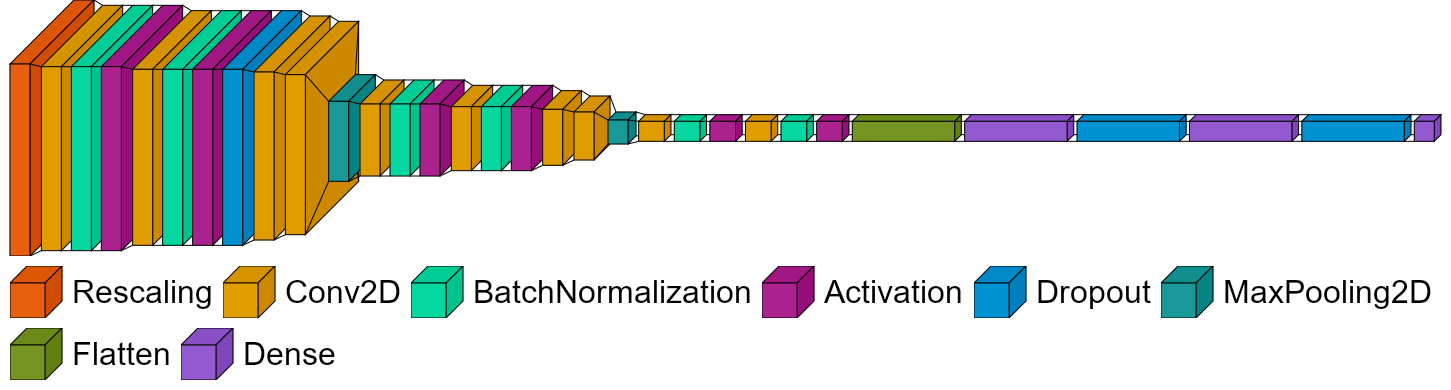

In [9]:
# creates and saves image of the emotion models layers
visualkeras.layered_view(emotion_classifier,
                         to_file='../../docs/emotion_classifier.png',
                         legend=True,
                         font=font,
                         color_map=color_map)

### Visualize Emotion Model Predictions

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


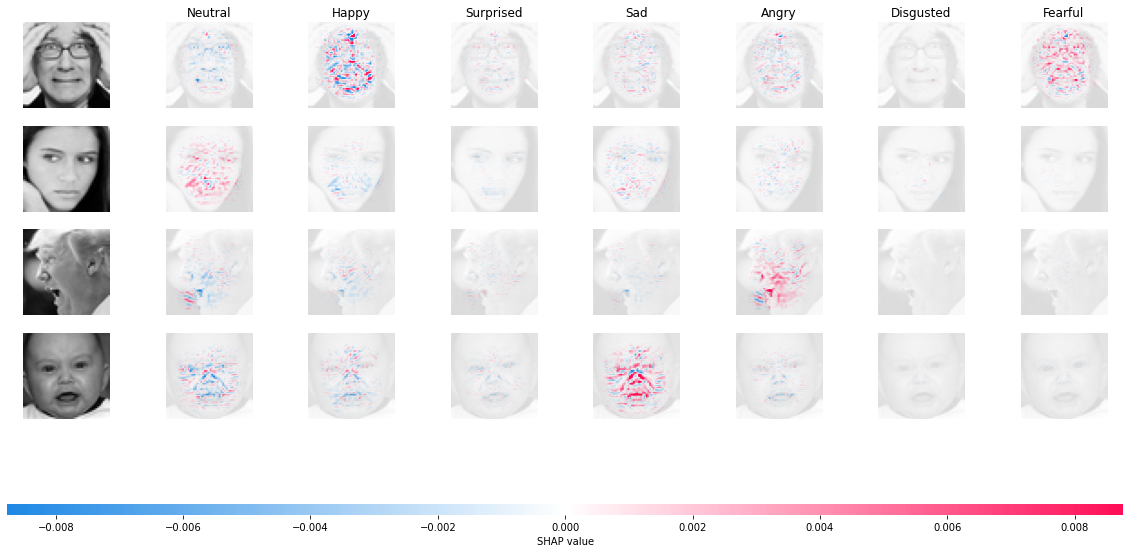

In [10]:
# creates the SHAP values for the demo pictures from emotion train set
emotion_values = emotion_explainer.shap_values(x_test_e[:4])

# creates the labels for the SHAP graph corresponding to the emotions in the app
index_names_emotion = np.array([['Neutral', 'Happy', 'Surprised', 'Sad', 'Angry', 'Disgusted', 'Fearful']])

# three empty rows have to be added so the shape matches the shape required by shap.image_plot
for i in range(3):
    index_names_emotion = np.append(index_names_emotion, np.array([['', '', '', '', '', '', '']]), axis=0)

shap.image_plot(emotion_values, x_test_e[:4], index_names_emotion)

## Age

### Load and Prepare Model and Data

In [11]:
age_classifier = load_model(os.path.join(os.path.dirname('__file__'), '../models/age_classifier.h5'))

In [12]:
def load_image(filename: str, size: tuple[int, int]) -> np.array:
    """Loads and resizes the image."""
    image = Image.open(filename).convert('L')
    resized_image = image.resize(size)
    return np.array(resized_image)

In [13]:
images = defaultdict()

path = '../../data/face_age'

# load the images from the corresponding subfolders
for subfolder in os.listdir(path):
    images_per_folder = glob.glob(f'{path}/{subfolder}/*.png')
    number_of_images = len(images_per_folder)
    key = int(subfolder.lstrip('0'))
    tmp = []

    for filename in images_per_folder:
        image = load_image(filename, size=(width, height))
        tmp.append(image)

    images[key] = tmp
    tmp = []

# maps the age to the corresponding age groups
child = []
young_adult = []
adult = []
senior = []

for key, value in images.items():
    if key <= 16:
        child += value
    elif 16 < key <= 30:
        young_adult += value
    elif 30 < key <= 60:
        adult += value
    else:
        senior += value

# puts age data back together into one data set
data_age = defaultdict()
data_age['child'] = child
data_age['young_adult'] = young_adult
data_age['adult'] = adult
data_age['senior'] = senior

In [14]:
# split data into input and labels, maps categories to the numbers (as used in the actual model)
X_a = np.array([])
y_a = np.array([])
labels_age = {
    'child': 0,
    'young_adult': 1,
    'adult': 2,
    'senior': 3,
}

for key, value in data_age.items():
    n = len(value)
    X_a = np.append(X_a, value)
    y_a = np.append(y_a, [labels_age[key]] * n)

X_a = X_a.reshape(-1, width, height, 1)

test_size_a = ceil(len(X_a) * 0.1)

# split data 90:10
x_train_a, x_test_a, y_train_a, y_test_a = train_test_split(X_a, 
                                                            y_a, 
                                                            test_size=test_size_a, 
                                                            random_state=42)

### Initialize Shap

In [15]:
# a smaller sample of the corresponding training set has to be used as background for the DeepExplainer
background_a = x_train_a[rng.choice(x_train_a.shape[0], 500, replace=False)]

In [16]:
age_explainer = shap.DeepExplainer(age_classifier, background_a)

### Visualize Age Model Architecture

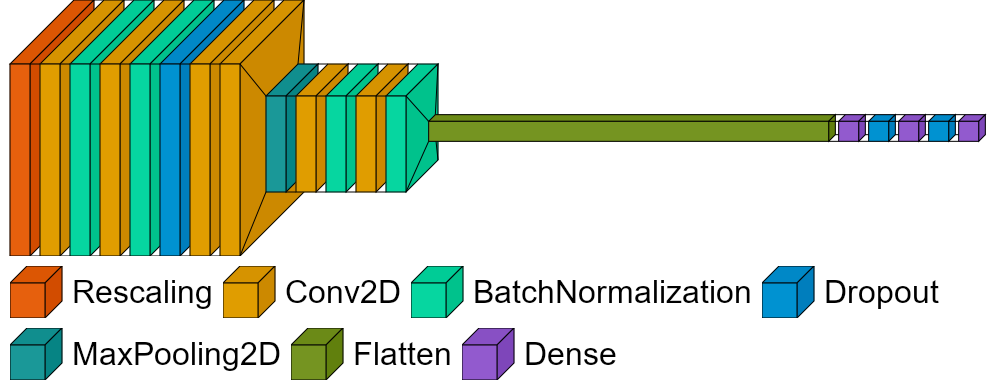

In [17]:
# creates and saves image of the age models layers
visualkeras.layered_view(age_classifier,
                         to_file='../../docs/age_classifier.png',
                         legend=True,
                         font=font,
                         color_map=color_map)

### Visualize Age Model Predictions

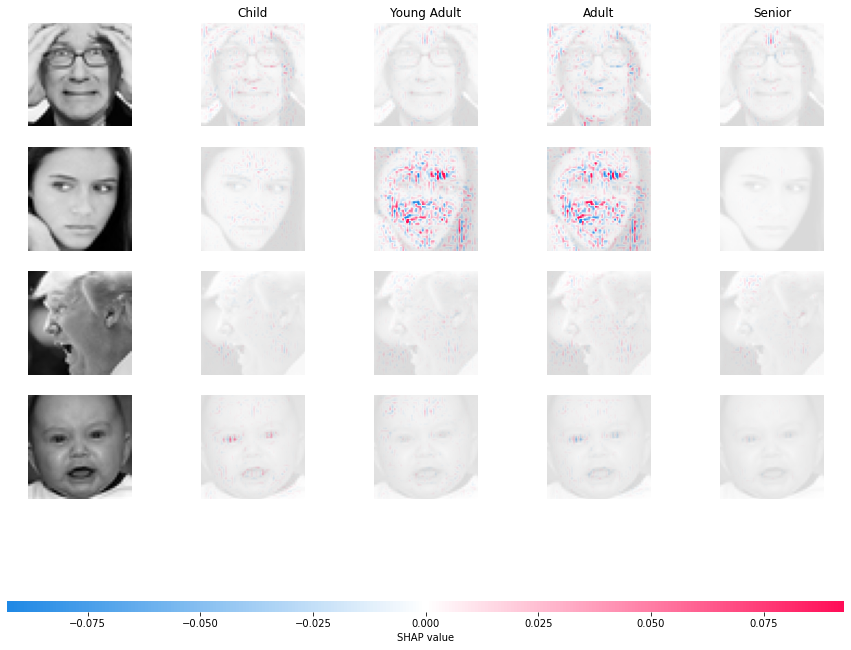

In [18]:
# creates the SHAP values for the demo pictures from emotion train set
# emotion set is used here intentionally to have the same pictures for both visualizations
age_values = age_explainer.shap_values(x_test_e[:4])

# creates the labels for the SHAP graph corresponding to the age groups in the app
index_names_age = np.array([['Child', 'Young Adult', 'Adult', 'Senior']])

# three empty rows have to be added so the shape matches the shape required by shap.image_plot
for i in range(3):
    index_names_age = np.append(index_names_age, np.array([['', '', '', '']]), axis=0)

shap.image_plot(age_values, x_test_e[:4], index_names_age)